In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import Model, load_model
from keras.optimizers import Adam
from keras.applications import ResNet152, DenseNet121, ResNet50
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten
from sklearn.metrics import classification_report
from keras.callbacks import EarlyStopping, CSVLogger, ReduceLROnPlateau

import os
from tensorflow.python.client import device_lib

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2131220269736540081
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10063183872
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10707135824662930450
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:b3:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


In [3]:
import splitfolders

splitfolders.ratio("./image_dataset", "./splitted", ratio=(0.7, 0.15, 0.15))

Copying files: 7733 files [00:29, 258.34 files/s]


In [11]:
train_dir1 = "./splitted/class1"
train_dir2 = "./splitted/class2"
train_dir3 = "./splitted/class3"
train_dir4 = "./splitted/class4"

for filename in os.listdir(train_dir2)[202:]:
    os.remove(os.path.join(train_dir2, filename))
for filename in os.listdir(train_dir3)[202:]:
    os.remove(os.path.join(train_dir3, filename))
for filename in os.listdir(train_dir4)[202:]:
    os.remove(os.path.join(train_dir4, filename))

49
79
964
73


In [5]:
# 데이터셋 경로 설정
base_dir = './splitted'

# ImageDataGenerator 설정
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    rotation_range=45,
    horizontal_flip=True,
    vertical_flip=True
    )

validation_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    rotation_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
    )

test_datagen = ImageDataGenerator(
    rescale=1./255
    )

# 데이터 로더 설정
train_generator = train_datagen.flow_from_directory(
    f'{base_dir}/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    color_mode="rgb"
    )

validation_generator = validation_datagen.flow_from_directory(
    f'{base_dir}/val',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    color_mode="rgb"
    )

test_generator = test_datagen.flow_from_directory(
    f'{base_dir}/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    color_mode="rgb",
    shuffle=False
    )

Found 884 images belonging to 4 classes.
Found 188 images belonging to 4 classes.
Found 196 images belonging to 4 classes.


In [2]:
model_path = "./model/weights/bug_classification_v1.0.5.h5"
history_path = "./model/history/bug_classification_v1.0.5.csv"

In [ ]:
params = {
    'input_shape' : (224, 224, 3), 
    'include_top': False,
    'weights':'imagenet',
    'classes': 4,
    "pooling" : "max"
}

# ResNet50 모델 로드 및 커스터마이징
base_model = DenseNet121(**params)

# 모델 커스터마이징
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation="relu")(x)
predictions = Dense(4, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# 일부 레이어만 학습되도록 설정
for layer in base_model.layers:
    layer.trainable = False

els = EarlyStopping(monitor="val_loss", patience=5, mode="min")
reduce = ReduceLROnPlateau(monitor="val_loss", patience=3, mode="min", factor=0.1)
csv_logger = CSVLogger(history_path)

model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# 모델 학습
model.fit(train_generator, epochs=100, validation_data=validation_generator, callbacks=[els, reduce, csv_logger])
model.save(model_path)

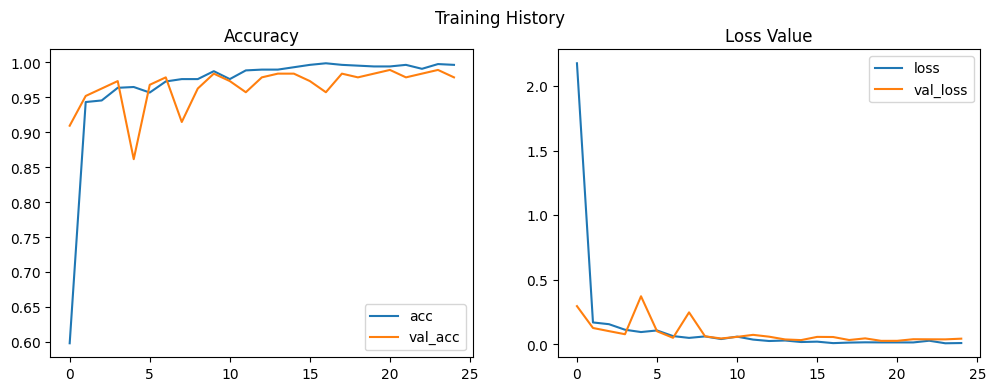

In [3]:
history = pd.read_csv(history_path)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history["epoch"], history["accuracy"], label="acc")
plt.plot(history["epoch"], history["val_accuracy"], label="val_acc")
plt.title("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history["epoch"], history["loss"], label="loss")
plt.plot(history["epoch"], history["val_loss"], label="val_loss")
plt.title("Loss Value")
plt.legend()

plt.suptitle("Training History")
plt.show()

In [4]:
model = load_model(model_path)
y_true = test_generator.classes
y_pred = []

for pred in model.predict(test_generator, verbose=0):
    y_pred.append(np.argmax(pred))

NameError: name 'test_generator' is not defined

In [23]:
print(classification_report(y_pred=y_pred, y_true=y_true))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        49
           1       0.98      0.98      0.98        49
           2       0.98      1.00      0.99        49
           3       1.00      0.98      0.99        49

    accuracy                           0.99       196
   macro avg       0.99      0.99      0.99       196
weighted avg       0.99      0.99      0.99       196



In [24]:
class_names = {0 : "미국선녀벌레", 1 : "썩덩나무노린재", 2 : "작은뿌리파리", 3 : "점나방"}

In [ ]:
import cv2
from glob import glob
import matplotlib as mlp

mlp.rcParams["font.family"] = "Malgun Gothic"
image_filenames = glob("./splitted/test/*/*.png")

fig, axis = plt.subplots(nrows=round(np.sqrt(len(test_generator.filenames))), ncols=round(np.sqrt(len(test_generator.filenames))), figsize=(80, 80))
plt.subplots_adjust(left=0.125, bottom=0.4, right=0.9, top=0.9, wspace=0.2, hspace=0.6)
plt.tight_layout(h_pad=1.08)

for idx, pred in enumerate(model.predict(test_generator, verbose=0)):
    img_array = np.fromfile(image_filenames[idx], np.uint8)
    img = cv2.imdecode(img_array, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    row_col = round(np.sqrt(len(test_generator.filenames)))

    true_class_idx = test_generator.classes[idx]
    pred_class_idx = np.argmax(pred)
    
    true_class_name = class_names[true_class_idx]
    pred_class_name = class_names[pred_class_idx]

    axis[idx//row_col][idx%row_col].imshow(image)
    axis[idx//row_col][idx%row_col].set_xlabel(f"true : {true_class_name}")
    axis[idx//row_col][idx%row_col].set_title(f"pred : {pred_class_name}")

plt.show()